# Hack or Hammer: Can Neural Networks Classify Stellar Types? ☀️🔨
[Github repo](https://github.com/yanbopanastro/UM-Astro-416-final-project)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
# Feedfoward Neural Networks Library
from keras.models import Sequential #the model is built adding layers one after the other
from keras.layers import Dense #fully connected layers: every output talks to every input
from keras.layers import Dropout #for regularization
from keras.utils import to_categorical
from keras_tuner.tuners import RandomSearch
from keras import layers

2025-04-26 11:08:50.686760: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-26 11:08:50.722122: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# I have written a seperate notebook for cleaner version of the main notebook
%run final_project_functions.ipynb   

## Introduction

- **What are spectral classes?**  
    Spectral classes categorize stars based on the absorption lines in their spectra, which relate to surface temperature and composition. The main classes are O, B, A, F, G, K, M (from hottest to coolest). In reality, astronomers need to use large telescopes and multi-fiber spectragraph to obtain spectra, reduce the raw data, and identify spectral features to classify stellar types. This method is robust, but require expensive telescope time and human efforts. In this project, we attempt to use fully-connected feedforward network (FFN) to classify spectral types with SDSS DR18 data. We hope this project could be informative to the feasibility of using neural networks for such task. 

- **Saha’s equation + Boltzmann’s equation**  
  Normally, we need to use Saha's equation and Boltzmann's equations to explain the population of energy levels and ionization states in stellar atmospheres. Due to different chemicals and temperature in the stellar atmospheres, we can observe different spectral features.
  - Saha’s equation determines ionization states.
    $$
    \frac{n_{i+1} n_e}{n_i} = \frac{2 Z_{i+1}}{Z_i} \left( \frac{2 \pi m_e k T}{h^2} \right)^{3/2} \exp \left( \frac{-\chi_i}{k T} \right)
    $$
  - Boltzmann’s equation determines excitation levels.
    $$
    \frac{n_j}{n} = \frac{g_j}{Z} \exp \left( \frac{-E_j}{k T} \right)
    $$

- **Example spectra**  
    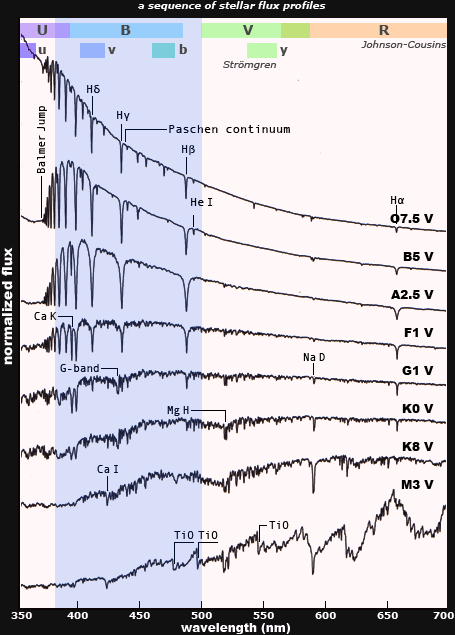


## Data exploration
In this project, we will be working with SDSS DR18 data. SDSS is a multi-spectral imaging and spectroscopic redshift survey using a 2.5-m wide-field optical telescope in New Mexico, US. We have randomly chosen 100,000 stars from Data Release 18 for this analysis.  <br>
**This is not a easy problem!** <br>
Why?: A easy temperature and color cut is not enough to seperate spectral classes. In reality, we have to measure the spectra (like the figure above) and identify absorption feature through the stellar atmosphere. 

number of rows after filtering: 74123


/tmp/ipykernel_9004/3054023678.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(grouped_temps, labels=class_labels, patch_artist=True,


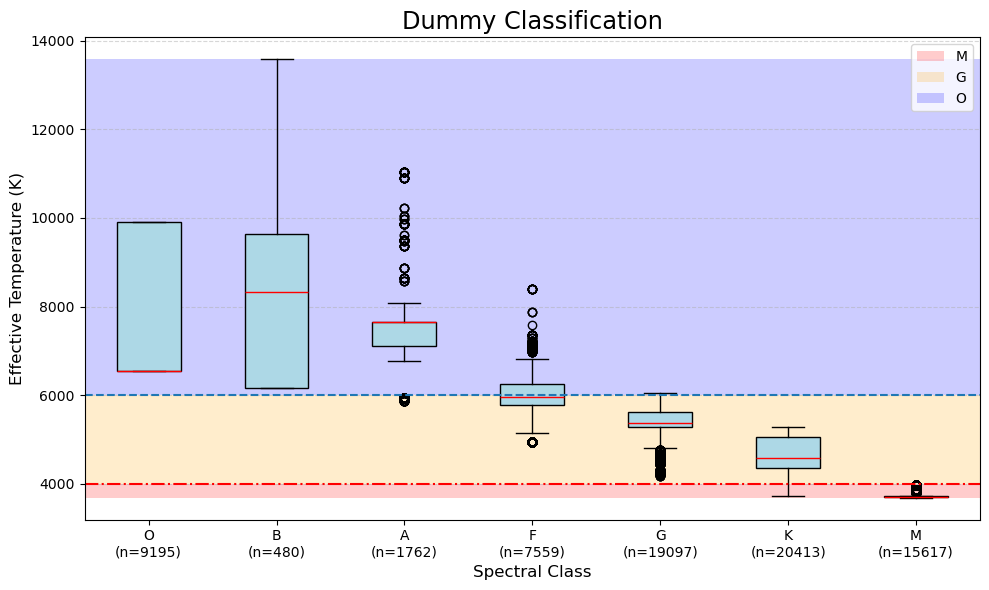

In [3]:
# read in data
df = pd.read_csv('SDSS.csv', header = 1)

# Extract first letter of spectral type
df['SpClass'] = df['elodieSpType'].str[0]

# Filter to valid spectral types and remove NaNs
valid_classes = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
df = df[df['SpClass'].isin(valid_classes)].dropna(subset=['elodieTEff'])
print(f'number of rows after filtering: {df.shape[0]}')

# Group TEff values and count per class
grouped_temps = []
class_labels = []

for cls in valid_classes:
    class_data = df[df['SpClass'] == cls]['elodieTEff'].values
    grouped_temps.append(class_data)
    class_labels.append(f"{cls}\n(n={len(class_data)})")  # Add count in label

plt.figure(figsize=(10, 6))
plt.boxplot(grouped_temps, labels=class_labels, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='black'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'))

plt.axhline(4000, linestyle = '-.', c = 'red')
plt.axhline(6000, linestyle = '--')
plt.axhspan(min(df['elodieTEff']), 4000, facecolor='red', alpha=0.2, label='M')
plt.axhspan(4000, 6000, facecolor='orange', alpha=0.2, label='G')
plt.axhspan(6000, max(df['elodieTEff']), facecolor='blue', alpha=0.2, label='O')

plt.xlabel('Spectral Class', fontsize = 'large')
plt.ylabel('Effective Temperature (K)', fontsize = 'large')
plt.title('Dummy Classification', fontsize = 'xx-large')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

We can correctly classigy all O, G, M stars using the dummy model.

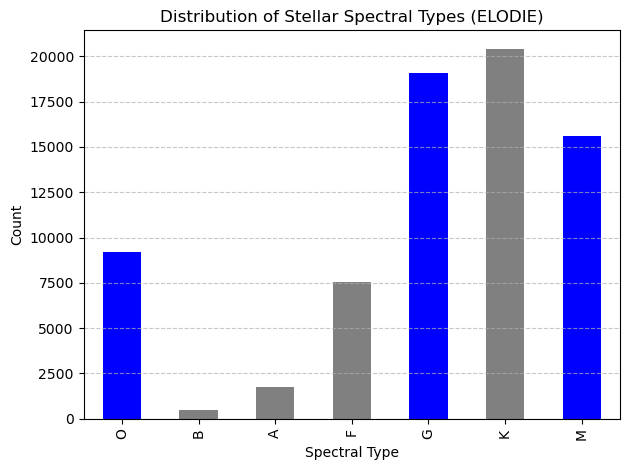

In [4]:
# Extract first letter and count frequencies
spectral_counts = df['elodieSpType'].str[0].value_counts()

# Desired spectral order
ordered_labels = ['O', 'B', 'A', 'F', 'G', 'K', 'M']

# Reindex to match OBAFGKM (missing types will be filled with NaN and skipped by default)
spectral_counts = spectral_counts.reindex(ordered_labels).fillna(0)

# Define colors: highlight O, G, M in blue, rest in grey
# colors = ['grey' for sp in spectral_counts.index]
colors = ['blue' if sp in ['O', 'G', 'M'] else 'grey' for sp in spectral_counts.index]

# Bar plot with custom order and colors
spectral_counts.plot(kind='bar', color=colors)
plt.xlabel('Spectral Type')
plt.ylabel('Count')
plt.title('Distribution of Stellar Spectral Types (ELODIE)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [5]:
# plt.scatter(df['elodieBV'], df['elodieTEff'], s = 1, alpha = 0.8)
# plt.xlabel('B-V')
# plt.ylabel('Effective Temperature (K)')

## Approach
<!-- - What is neural network?
- How it can be useful and not useful?
- What is CV?
- Explain why this model choice is suitable for the dataset
- Strength and weakness of this method -->

### Benchmark model 📊
First, we will set up a dummy benchmark model. We know effective temperature is only a way for us to measure the stellar flux. However, it can inform us of approximately how hot the star is, using first order approximation. Therefore, we set up our dummy model to be:
- M star if $T_{eff}$ < 4000 K
- G star if 4000 K < $T_{eff}$ < 6000 K
- O star if 6000 K < $T_{eff}$

In this case, we sucessfully classify all O, G, and M stars and misclassify all other stars. This model is decent in its accuracy (59.2%) and recall (59.2%). However, it performs poorly regarding its precision (37.2%) and f1 score (45.1%). This motivates us to use a more complex and flexible model to classify spectral types. 

In [6]:
df['dummySpClass'] = df['elodieTEff'].apply(
    lambda T: 'M' if T < 4000 else ('G' if T <= 6000 else 'O')
)
print(f"accuracy: {accuracy_score(df['SpClass'], df['dummySpClass'])}")
print(f"percision: {precision_score(df['SpClass'], df['dummySpClass'], average='weighted', zero_division=0)}")
print(f"recall: {recall_score(df['SpClass'], df['dummySpClass'], average='weighted')}")
print(f"f1 score: {f1_score(df['SpClass'], df['dummySpClass'], average='weighted')}")

accuracy: 0.5921643754300284
percision: 0.3719782941836962
recall: 0.5921643754300284
f1 score: 0.4505768063570703


For the input X matrix, we use various stellar parameter inputs. 

| Feature   | Description                          | Data Type |
|---------------|--------------------------------------|-----------|
| `ra`          | Right Ascension                      | float     |
| `dec`         | Declination                          | float     |
| `u`           | SDSS u-band magnitude                | float     |
| `g`           | SDSS g-band magnitude                | float     |
| `r`           | SDSS r-band magnitude                | float     |
| `i`           | SDSS i-band magnitude                | float     |
| `z1`          | SDSS z-band magnitude                | float     |
| `dered_u`     | Dereddened u-band magnitude          | float     |
| `dered_g`     | Dereddened g-band magnitude          | float     |
| `dered_r`     | Dereddened r-band magnitude          | float     |
| `dered_i`     | Dereddened i-band magnitude          | float     |
| `dered_z`     | Dereddened z-band magnitude          | float     |
| `elodieBV`    | B–V color index from ELODIE match    | float     |
| `elodieTEff`  | Effective temperature (Kelvin)       | int       |
| `elodieLogG`  | Log surface gravity                  | float     |
| `elodieFeH`   | Metallicity [Fe/H]                   | float     |

The output of the model is a array of probability values bounded between 0 and 1. The sum of the probability array is 1. We will take the element with the highest probability to be the predicted spectral class. 

In [7]:
# Select only the numeric columns from the SDSS DataFrame
numeric_col = df.select_dtypes(include='number').columns.tolist()
# removing irrelevant feature
numeric_col = [col for col in numeric_col if col not in ['specObjID', 'err_u', 'err_g', 'err_r', 'err_i', 'err_z']] 
X = df[numeric_col]
y = df['SpClass']
# print(X.dtypes)

#### Data Preprocessing
- Data splitting <br>
To evaluate the performance the ML method, we will split the data into three different groups: training, validation, testing using standard index split.

- Standardization <br>
One important thing to do before running any neural networks is to standardize the data. Here, we use `StandardScaler()` from the `scikit-learn` package. If the initial data is not standardized, we may get unphysically high or low gradient in different direction of the parameter space. For instance, the effective temperature may vary on the order of thousands in Kelvin, while the photometry parameter may only cary on the order of 0.1 in dex. 


- One hot encoding <br>
One extra preprocessing step is to convert the array of spectral class containing only 0 and 1 into a two-dimensional matrix containing only 0 and 1. With each row only containing 1, indicating the true class. This is a work around of how keras handle classification task. 

| Spectral Class | One-Hot Encoding           |
|----------------|----------------------------|
| O          | [1, 0, 0, 0, 0, 0, 0]       |
| G          | [0, 0, 0, 0, 1, 0, 0]       |
| M          | [0, 0, 0, 0, 0, 0, 1]       |


In [8]:
# Shuffle the data and target labels while preserving the correspondence
X,y = shuffle(X,y, random_state = 406)
# slight modification to the catergorical output
le = LabelEncoder()
y_encoded = le.fit_transform(y)          # Converts to integers: [0, 1, 2, ...]
y_categorical = to_categorical(y_encoded)  # One-hot encode

# --- Manually splitting our dataset
# Use 70/20/10 split here
split1 = int(0.7*len(X))
split2 = int(0.9*len(X))
# First 70% samples will be the training set
X_train = X.values[:split1,:]
y_train = y_categorical[:split1]
# Next 20% samples will be the validation set, used to minimize loss function
X_val = X.values[split1:split2,:]
y_val = y_categorical[split1:split2]
# Last 10% samples will be the test set, used to test the model performance
X_test = X.values[split2:,:]
y_test = y_categorical[split2:]

# use StandardScaler() to scale the dataset
scaler = StandardScaler()
scaler.fit(X_train)

# transform each set individually to avoid data leakage
Xst_train = scaler.transform(X_train)
Xst_val = scaler.transform(X_val)
Xst_test = scaler.transform(X_test)

# Confirm the shapes of the datasets
print(X_train.shape, X_val.shape, X_test.shape)

(51886, 16) (14824, 16) (7413, 16)


## Machine Learning 🤖🧠🦾
- In this project, we use neural networks as the main ML method. 
- This is a multiclass classification problem as we have multiple catergorical outcomes (OBAFGKM)
- This is a supervised task since we already have labelled data from SDSS. The spectral labels are done through the [ELODIE spectrograph](https://en.wikipedia.org/wiki/ELODIE_spectrograph).

<a href="https://udlbook.com/" target="_blank">
  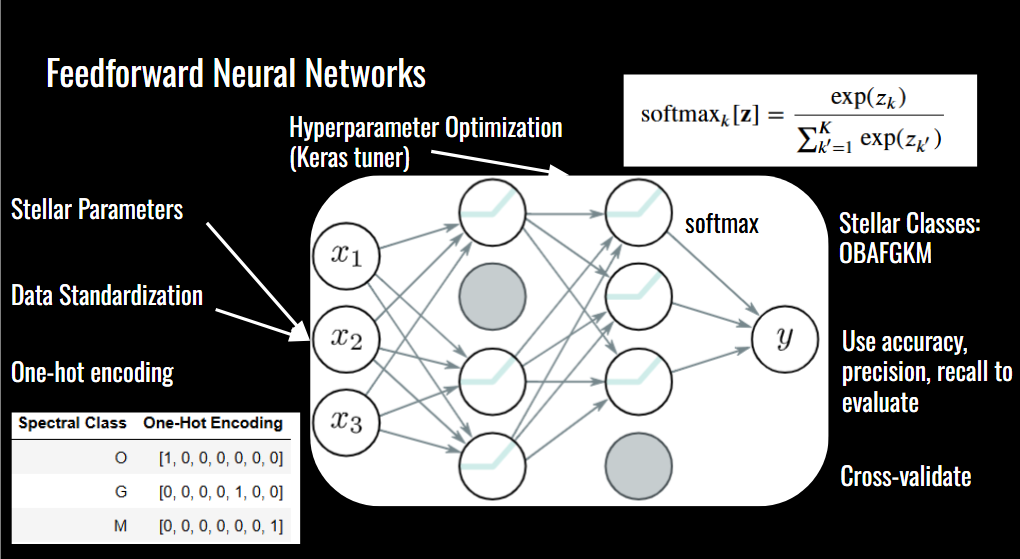
</a>

### Crash Course into Neural Networks
- Neural networks (NN) is a flexible machine learning technique. It can fit any arbitary function or classification as described in the universal approximation theorem. This is because its primary building blocks: neurons are non-linear functions. I am using the ReLU (rectified linear unit) in this project. When we adding all these non-linear features together, we can build a very flexible model. 

$$
\text{ReLU}(x) = \max(0, x)
$$

- This is a feedforward network since all the information is pass-along the same "right" direction. We first feed-in the standardized stellar parameters, like effective temperature, photometry, etc. Then, the neural net can do its non-linear magic and output arbitary linear output in the second last layer. For the last layer, we impose a softmax function in the last layer to convert the unbounded real number output to probabilities bounded between 0 and 1. Then, we take the class with the highest probability and compare with the label in the dataset. 

### Multiclass Classification Background

The loss function for multiclass classification is:
> **Multiclass cross-entropy loss**
$$L[\phi] = -\sum_{i=1}^{I} \log \left( \text{softmax}_{y_i} \left[ f(\mathbf{x}_i, \phi) \right] \right)$$
$$L[\phi] = -\sum_{i=1}^{I} f_{y_i}[\mathbf{x}_i, \phi] - \log \left( \sum_{k=1}^{K} \exp \left[ f_k[\mathbf{x}_i, \phi] \right] \right)$$

The loss function arises from our assumption that the underlying occurance rate for each spectral class follows a multinomial distribution, which is valid both from our prior knowledge on stellar astrophysics and the histogram plot (figure 2). 

Using the definition of the softmax function:

$$\text{softmax}_k[\mathbf{z}] = \frac{\exp(z_k)}{\sum_{k'=1}^{K} \exp(z_{k'})}$$

#### The number of parameters
One concern I have before running any neural network for this task is the number of parameter may outnumber the number of observations. The number of parameters will explode quadratically with the number of neurons. Therefore, I limit myself to the neural network architecture with only a few neurons in each layer to avoid overfitting. I also add in dropout to each hidden layer to avoid strong dependence on certain neurons and overfitting. 

Most of architecture used in this notebook have parameter on the order of 1,000, while we have over 51,000 training data. So, overfitting is not a huge concern. ;)

## Initial Results
Let's try a simple neural net model with only 2 hidden layers, each with 16 neurons, with only 663 parameters.

In [9]:
# Set up the NN model with the 3 layers
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(Xst_train.shape[1],))) # hidden layer with 16 neurons
model.add(Dropout(0.2))                                                    # drop 20% of neurons
model.add(Dense(16, activation='relu'))                                    # hidden layer with 16 neurons
model.add(Dropout(0.2))                                                    # drop 20% of neurons
model.add(Dense(y_train.shape[1], activation='softmax'))                   # output as softmax probabilities

# set up and assign the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)                  # Adam optimizer use momentum to optimize well

# compile the model
# use cross_entropy for classification loss function
model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics =['accuracy'])
model.summary() #print summary of the best model
mynet = model.fit(Xst_train, y_train, validation_data= (Xst_val, y_val), epochs = 50, batch_size=200)

/home/yanbopan/anaconda3/envs/astro-416/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 663 (2.59 KB)

 Trainable params: 663 (2.59 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6573 - loss: 0.9487 - val_accuracy: 0.9446 - val_loss: 0.1972
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8871 - loss: 0.3415 - val_accuracy: 0.9447 - val_loss: 0.1594
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9037 - loss: 0.2736 - val_accuracy: 0.9381 - val_loss: 0.1568
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9083 - loss: 0.2620 - val_accuracy: 0.9593 - val_loss: 0.1454
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9173 - loss: 0.2520 - val_accuracy: 0.9392 - val_loss: 0.1504
Epoch 6/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9187 - loss: 0.2371 - val_accuracy: 0.9495 - val_loss: 0.1341
Epoch 7/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9200 - loss: 0.2322 - val_accuracy: 0.9406 - val_loss: 0.1570
Epoch 8/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9215 - loss: 0.2335 - val_accuracy: 0.

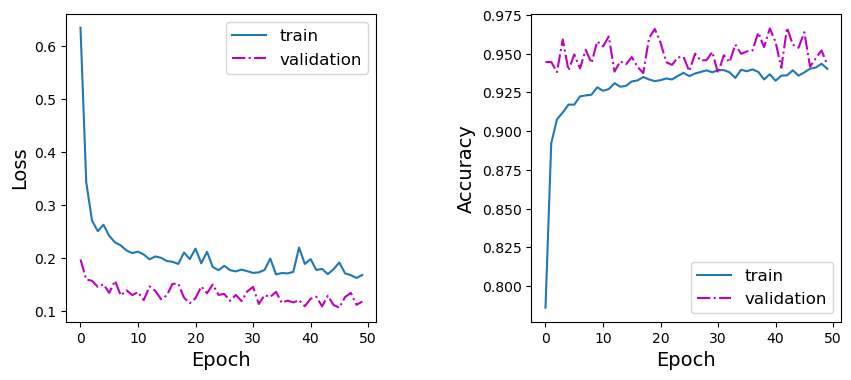

In [10]:
########## Sometimes, the neural net weights do not get initialized  ##########
########## This may leads to the higher performance on the validation sets than training sets  ##########

fig = plt.figure(figsize=(10, 4))
plt.subplot(121)

plt.plot(mynet.history['loss'], label = 'train')
plt.plot(mynet.history['val_loss'], '-.m', label = 'validation')
# plt.yscale('log')
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)
plt.legend(loc='upper right', fontsize = 12)

plt.subplot(122)

plt.plot(mynet.history['accuracy'], label = 'train')
plt.plot(mynet.history['val_accuracy'], '-.m', label = 'validation')
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)
plt.legend(fontsize = 12)
plt.subplots_adjust(wspace=0.5)

The performance of this simple model is not bad. Most of the test samples are correctly classified along the diagonal line of the confusion matrix (high accuracy). For the misclassified stars, they are only one class away from their true class. There are no major misclassfied stars, like O stars misclassified as M stars. 

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


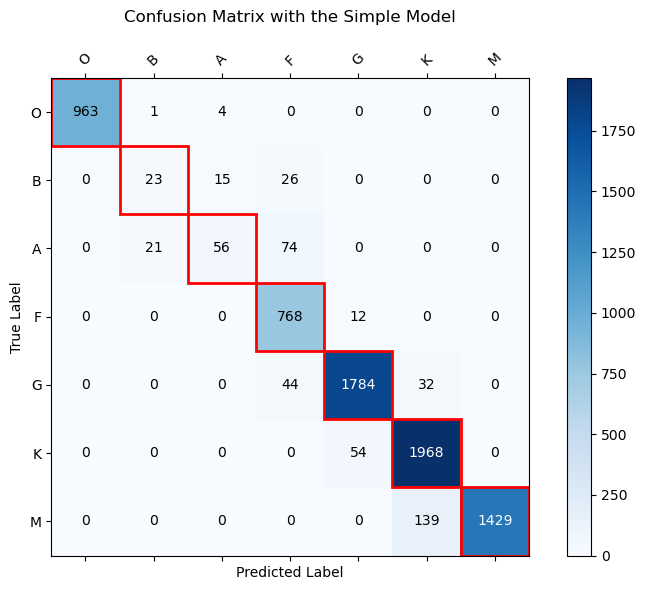

In [11]:
ordered_labels = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
plot_confusion_matrix(model, Xst_test, y_test, le, ordered_labels, title='Confusion Matrix with the Simple Model')

## Final Results
<!-- <span style="color:red">Create customized metrics here</span>.
#### I will be sad if a O star is being labelled as M -->
### Hyperparameter Tuning 🔧
For the final results, we will use hyperparameter tuning to find the optimized hyperparameters for our task. <br>
Hyperparameter tuning is the process of optimizing the configuration parameters that are not learned during training, such as:
- Number of layers
- Neurons per layer
- Learning rate
- Drop out rate

Instead of manually guessing these values, Keras tuner automatically search through different combinations to find the best-performing model. This improves performance and generalization by systematically exploring the hyperparameter space.

In [12]:
# Fill in the code from the textbook
def build_model(hp):
    """
    Builds a Keras sequential model with tunable hyperparameters.
    Parameters:
        hp: HyperParameters object from Keras Tuner, used to define the search space.
    Returns:
        model: A compiled Keras Sequential model ready for training.
    """

    # Initialize a sequential model
    model = keras.Sequential()
    
    # Add hidden layers with tunable number of layers, units per layer, and dropout rate
    for i in range(hp.Int('num_layers', 2, 4)):
        # Add a dense (fully connected) layer
        model.add(layers.Dense(
            units=hp.Int('units_' + str(i), min_value=16, max_value=64, step=16),  # Units per layer
            activation='relu'  # Activation function for non-linearity
        ))
        # Add dropout regularization after each dense layer
        model.add(layers.Dropout(
            rate=hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.6, step=0.2)  # Dropout rate per layer
        ))

    # Add the output layer
    # Number of output units matches the number of classes, with softmax activation for multiclass probability output
    model.add(Dense(y_train.shape[1], activation='softmax'))

    # Define optimizer with tunable learning rate
    optimizer = tf.keras.optimizers.Adam(
        hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    )

    # Compile the model with mean squared error loss (assuming labels are one-hot encoded)
    model.compile(optimizer=optimizer, loss='mse')

    return model

In [13]:
tf.keras.backend.clear_session() # clear the session to avoid clutter from old models

# Set up the tuner variable (see book) and provide comments to describe what is happening
tuner = RandomSearch(build_model, objective='val_loss', max_trials = 40, executions_per_trial = 3, project_name = 'SpectralClass_1')
# build_model: provide a series of model (parameters) to tune/choose
# objective: specifies the direction of the optimization and what loss function to use on which dataset. 
# max_trials: the totoal number of trials to test at most for the random search
# executions_per_trial: since the model performance is dependent on the the intial condition, therefore, it is good to run models several times
#                        here, we run each model 3 times to average the randomness
# project_name: name of the directory where tuning results will be saved

tuner.search_space_summary()

Reloading Tuner from ./SpectralClass_1/tuner0.json
Search space summary
Default search space size: 10
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.6, 'step': 0.2, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.6, 'step': 0.2, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0

In [14]:
### takes a LONG LONG LONG time to run ###
tuner.search(Xst_train, y_train, epochs = 50, validation_data = (Xst_val, y_val), batch_size = 128, verbose = 0)

In [15]:
# let's take a look at the top 5 models
tuner.results_summary(5)

Results summary
Results in ./SpectralClass_1
Showing 5 best trials
Objective(name="val_loss", direction="min")

Trial 02 summary
Hyperparameters:
num_layers: 4
units_0: 32
dropout_0: 0.0
units_1: 48
dropout_1: 0.2
learning_rate: 0.001
units_2: 64
dropout_2: 0.2
units_3: 16
dropout_3: 0.0
Score: 0.00185727762679259

Trial 25 summary
Hyperparameters:
num_layers: 3
units_0: 16
dropout_0: 0.0
units_1: 64
dropout_1: 0.0
learning_rate: 0.001
units_2: 48
dropout_2: 0.2
units_3: 32
dropout_3: 0.0
Score: 0.0025898159947246313

Trial 28 summary
Hyperparameters:
num_layers: 2
units_0: 32
dropout_0: 0.0
units_1: 48
dropout_1: 0.0
learning_rate: 0.01
units_2: 16
dropout_2: 0.0
units_3: 48
dropout_3: 0.2
Score: 0.0032296031713485718

Trial 06 summary
Hyperparameters:
num_layers: 4
units_0: 48
dropout_0: 0.2
units_1: 16
dropout_1: 0.0
learning_rate: 0.01
units_2: 16
dropout_2: 0.0
units_3: 48
dropout_3: 0.2
Score: 0.0038531587148706117

Trial 33 summary
Hyperparameters:
num_layers: 3
units_0: 64
drop

In [16]:
best_hps = tuner.get_best_hyperparameters()[0] #choose first model

print('Best learning rate:', best_hps.get('learning_rate'))
print('Best number of layers:', best_hps.get('num_layers'))

print('Best units in layer 0:', best_hps.get('units_0'))
print('Best units in layer 1:', best_hps.get('units_1'))
print('Best units in layer 2:', best_hps.get('units_2'))
print('Best units in layer 3:', best_hps.get('units_3'))

Best learning rate: 0.001
Best number of layers: 4
Best units in layer 0: 32
Best units in layer 1: 48
Best units in layer 2: 64
Best units in layer 3: 16


In [17]:
bestmodel = tuner.hypermodel.build(best_hps) #define model = best model
bestmodel.build(input_shape=(None,Xst_train.shape[1])) #build best model (if not fit yet, this will give access to summary)
bestmodel.summary() #print summary of the best model

bestnet = bestmodel.fit(Xst_train, y_train, validation_data= (Xst_val, y_val), epochs=20, batch_size=300)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 48)             │         1,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,423 (25.09 KB)

 Trainable params: 6,423 (25.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0925 - val_loss: 0.0279
Epoch 2/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0316 - val_loss: 0.0185
Epoch 3/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0228 - val_loss: 0.0161
Epoch 4/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0196 - val_loss: 0.0147
Epoch 5/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0171 - val_loss: 0.0136
Epoch 6/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0159 - val_loss: 0.0119
Epoch 7/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0138 - val_loss: 0.0112
Epoch 8/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0126 - val_loss: 0.0105
Epoch 9/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0122 - val_loss: 0.0102
Epoch 10/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0113 - val_loss: 0.0097
Epoch 11/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0117 - val_loss: 0.0083
Epoch 12/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

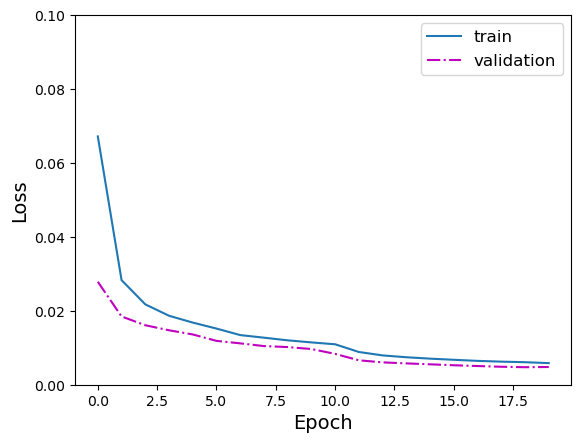

In [18]:
plt.plot(bestnet.history['loss'], label = 'train')
plt.plot(bestnet.history['val_loss'],'-.m', label = 'validation')
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)
plt.ylim(0,0.1)
plt.legend(loc='upper right', fontsize = 12)
plt.legend(fontsize = 12)

Note in this confusion matrix, none of the stars is classified as B or A star. This could be caused by the randomness associated with data splitting. There may be a few or zero B or A stars in the training set, which leads to misclassification to these two classes. So, we need to implement cross validation to obtain a more comprehensive measure of the model performance. 

232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


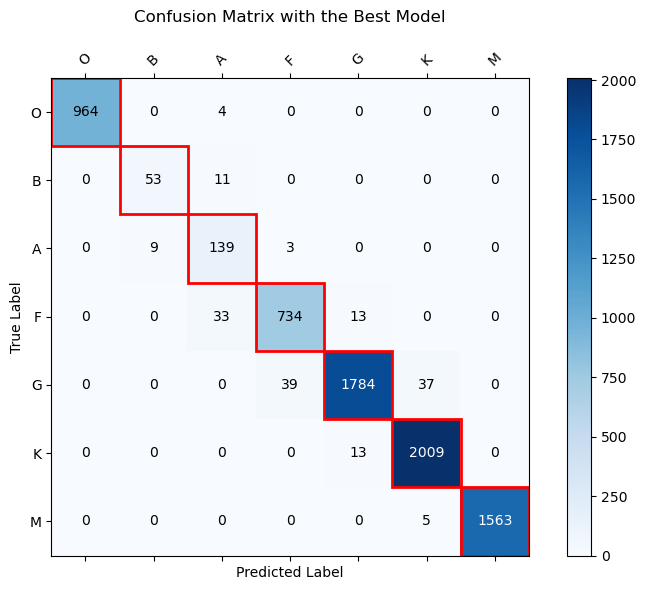

In [19]:
ordered_labels = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
plot_confusion_matrix(bestmodel, Xst_test, y_test, le, ordered_labels, title='Confusion Matrix with the Best Model')

### Let's Cross Validate (CV)
CV is a way for us to assess how well the model generalize to unseen data. We first split the dataset into different folds, training the model on a subset, and validating it on the remaining fold. This process is iterated for K times (K-fold CV). CV helps us reduce overfitting and gives a more reliable estimate of model performance with error bars/uncertainties. 

#### There are many metrics we can use
> How many predictions (both positive and negative) were correct overall
$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$
How many of the predicted positives are correct
$$\text{Precision} = \frac{TP}{TP + FP}$$
How many of the actual positives were correctly predicted
$$\text{Recall} = \frac{TP}{TP + FN}$$
F1 accounts for both percision and recall
$$\text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

In [20]:
# CV Setup
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=406)

# Store metrics
accs, precs, recalls, f1s = [], [], [], []

# Loop over folds
_ = to_categorical(le.fit_transform(y))
for train_index, val_index in skf.split(X, y):
    Xtrain, Xval = X.iloc[train_index], X.iloc[val_index]
    ytrain, yval = y_categorical[train_index], y_categorical[val_index]

    # scale X data inside CV, remember to use the scaled version of data
    scaler = StandardScaler()
    scaler.fit(Xtrain)
    Xst_train = scaler.transform(Xtrain)
    Xst_val = scaler.transform(Xval)
    
    # Build and train model
#     model = tuner.hypermodel.build(best_hps)
#     model.build(input_shape=(None,Xst_train.shape[1]))
#     model.fit(Xst_train, ytrain, epochs=20, batch_size=300, verbose=0)

    bestmodel = tuner.hypermodel.build(best_hps)
    bestmodel.build(input_shape=(None, Xst_train.shape[1]))
    bestmodel.fit(Xst_train, ytrain, epochs=20, batch_size=300, verbose=0)

    # Predict
    yval_pred_probs = bestmodel.predict(Xst_val)
    yval_pred = yval_pred_probs.argmax(axis=1)
    yval_true = yval.argmax(axis=1)

    # Compute metrics
    accs.append(accuracy_score(yval_true, yval_pred))
    precs.append(precision_score(yval_true, yval_pred, average='weighted', zero_division=0))
    recalls.append(recall_score(yval_true, yval_pred, average='weighted'))
    f1s.append(f1_score(yval_true, yval_pred, average='weighted'))

# Report results with error bars
print(f'Accuracy: {np.mean(accs):.3f} ± {np.std(accs):.3f}')
print(f'Precision: {np.mean(precs):.3f} ± {np.std(precs):.3f}')
print(f'Recall: {np.mean(recalls):.3f} ± {np.std(recalls):.3f}')
print(f'F1-score: {np.mean(f1s):.3f} ± {np.std(f1s):.3f}')

464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
464/464 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.979 ± 0.004
Precision: 0.978 ± 0.005
Recall: 0.979 ± 0.004
F1-score: 0.978 ± 0.005


232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


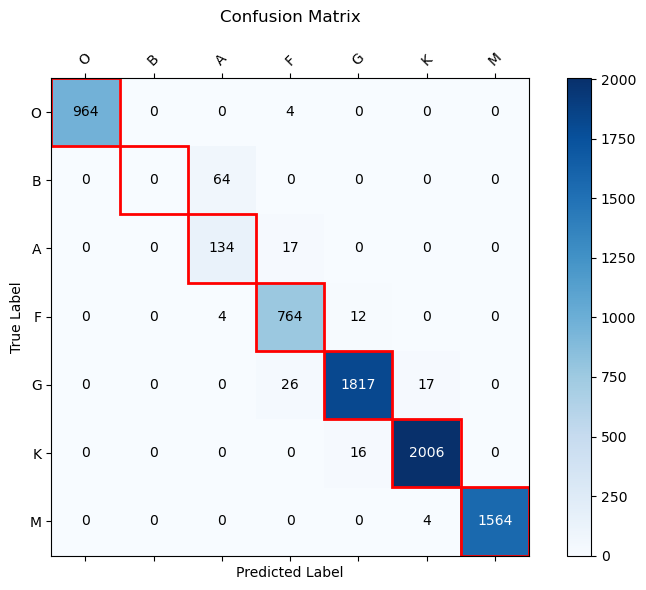

In [21]:
ordered_labels = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
plot_confusion_matrix(bestmodel, Xst_test, y_test, le, ordered_labels)

## Reflection


### Model Performance: It worked!
<!-- - **What did we found? Did the NN performs well?**
- **Is this a good mathod or just a hammer?** -->


The neural network technique worked in classifying the spectral types. All statistical metrics (accuracy, precision, recall, and F1-score have significantly improved compared to the dummy model and the simple network. 

| Metric    | Performance | Standard Deviation | Benchmark Performance |
|-----------|--------------|--------------------|-------------------|
| Accuracy  | 0.981        | ± 0.001             | 0.592             |
| Precision | 0.981        | ± 0.002             | 0.372             |
| Recall    | 0.981        | ± 0.001             | 0.592             |
| F1-score  | 0.980        | ± 0.002             | 0.451             |

We have an intuitive explanation of why this architecture works well. 
- We have multiple hidden layers (32, 48, 64, 16) that changes in feature space. This allows the network to first feature engineer a lot of information and then compress into more compact representations. This hourglass shape is also seen from other famous network strcutures like U-Net and autoencoders. 
- At some layers, we apply dropout: randomly muting some neurons during training. This is a powerful regularization technique which prevents the model from overfitting the training data. So, this method helps with generalization to unseen data. 
- The number of trainable parameters is 6,423 which is smaller than the number of observations. This is also a good sign that we are not overfitting. 

### Motivation and Application
<!-- - Motivation
- Future application/big picture LSST, DES
- Can it outperforms astronomer classification? -->

- This project is motivated by one feature in the DECam Local Volume Survey (DELVE), where they use neural networks to classify wherther objects are stars or galaxies based on point spread function and image data. This is a useful feature to allow people working on low-redshift stars and high-redshift galaxies to have clean data. This motivates me to apply neural networks to classify spectral types, so that stellar astronomers can also get a clean sample of stars they want to work on quickly. 
- The ability to harness the computing power is essential in this large-scale survey era. With the ongoing SDSS/DES and the upcoming LSST, we can apply this models with good accuracy to these sky surveys data to predict spectral types. Stellar astronomers can obtain relatively clean samples to work on after filtering the spectral types. 
- One interesting question to ask is "can the neural net model outperform human classification using spectra?". It will be super cool if we can do a Star Zoo in Zooniverse and compare the machine accuracy versus human accuracy. 


### Limitations
<!-- - The label in the dataset may not be true. 
- Class imbalance
- Photometric uncertainty not included
- AI vs Domain knowledge; Interpretability -->

We have to acknowledge several limitations this term project may have. 
- The SDSS spectral classification may not be 100% correct. The original spectral classification is based on the ELODIE library (Prugniel & Soubiran 2001), and the original classification may have some errors that we have accounted for in this project. Therefore, this uncertainty may propogate to the neural net weights.
- Moreover, we have imbalanced distribution among different spectral classes. In our sample, `O, F, G, K, M` stars dominate the dataset, while `B and A` stars only compose a few percent of the dataset. Therefore, the model performance is not well on B and A stars. A more balanced dataset will better train the model.
- We treat photometric measurements and effective temperature as exact values, while these measurements come with uncertainties. Ignoring these observational errors may cause the model to overfit and perform poorly to a new dataset. 
- The biggest limitation of neural networks is the low interpretability. Unlike physically motivated models, it is difficult to understand how a neural network is making its classification decisions. While the network may accurately predict spectral classes, it lacks transparency. It is hard to extract scientifically meaningful rules or patterns from the model.

### Future Improvements
<!-- - Leave some features out and see what happens, undergrad project?
- Subclass classification -->

- If we have more time, we can investigate how individual features play in the prediction. For example, we can train the model with some features removed (like leave out u magnitude or effective temperature) and see how the classification performance is changed. This is useful since not all surveys will have the effective temperature information or photometry across all 5 bands. Perhaps this would be a good undergraduate projects for students interested in both astronomy and data science?
- Another improvement would be to extend the model from crude spectral types to finer subclass.. This offers a better understanding of stellar properties and potentially allow for more precise mapping to their physical characteristics. This is feasible to extend since the dataset have the subclass information. 

## AI Statement
### Responsible use
<!-- Clearly states which AI tools were used, what portions of the code was assisted, and includes detailed code comments showing understanding. Demonstrates responsible use.  -->

For this project, ChatGPT was used to assist debugging and finding ways to have multiclass classification work using keras. ChatGPT is used to help writing the one-hot encoding, `plot_confusion_matrix`, and `build_model` function.  

All code was manually reviewed and tested. Detailed comments were added in this notebook. The model design, validation method, and results were based on my understanding from the course materials and previous research. 


### Discovery
<!-- Classes and functions discovered through AI (i.e., any advanced library NOT used in this course) are clearly described in this section; demonstrates good initial understanding of class/function use. If only using functions and classes covered during the course, write a brief description of the main scikit-learn or keras libraries used to demonstrate that you have reviewed the documentation and understand the relevant inputs and settings. -->


In this project, we found the `F1 score` and `one-hot encoding` to be useful. 
- The F1 score was used as a key performance metric. It is the harmonic mean of precision and recall. It is helpful when working with imbalanced data, which is true for this dataset. I used `f1_score` function from `sklearn.metrics`, with the argument `average='weighted'` to account for the imbalance between spectral classes.
- We used the one-hot encoding to prepare the catergorical labels for training neural networks. The `to_catergorical` function from `tensorflow.keras.utils` was applied to transform integer array into binary class matrix. This allows the model to output full probability distribution over class. 

Main scikit-learn functions:
- I used `StratifiedKFold` to split the data into K=5 folds for cross-validation while keeping the percentage of samples for each class. The important arguments I used were `n_splits=5` for 5-fold CV, `shuffle=True` to randomize before splitting, and setting a `random_state` for reproducibility.
- I applied `StandardScalar` to standardize the input features by removing the mean and scaling the standard deviation to 1. The scaler was fitted only to the training dataset to avoid data leakage. 
- We calculated `accuracy_score`, `precision_score`, `recall_score`, and `f1_score` to evaluate the model performance. We used `average=weighted` in precision, recall, and F1-score to account for class imbalance and set `zero_division=0` to handle missing classes in predictions.

Main keras functions:
- We built the neural net using the `Sequential` function, stacking layers one on top of another. This is suitable for our case since we do not require any residual connections or any recurrent structure. 
- `to_catergorical` was used to do the one-hot encoding the integer labels, transforming the result to a format compatible to softmax probabilities. 
- We used Keras Tuner `RandomSearch` to optimize learning rates, number of neurons, and the number of layers. We specify the `objective=val_loss`, `max_trials`, and `executions_per_trial` to control the search space and run time. More detailed documentation can be found in the `RandomSearch` cell. 